# Adding income information to a synthetic population of households

In this example, we already have a synthetic population of households on Nantes city. This synthetic population was built using the French national Census of the population. For each household, serveral characteristics have been added:

- Ownership : owner or tenant of its accomodation
- Age : age of reference person
- Size : number of persons
- Family composition : composition (single person, couple with ou without children, etc)

The objectif is to add income information to each household. In order to reach this goal, we use another data source named Filosofi. More precisely, this data source gives information on the income distribution (deciles) for each city, per household characteristics.

Filosofi is an indicator set implemented by INSEE which is the French National Institute of Statistics. See [insee.fr](https://www.insee.fr/fr/metadonnees/source/serie/s1172) for more details.


## Data preparation

Read synthetic population which doesn't contain revenu information.

In [1]:
import pandas as pd

SEED = 42

synth_pop = pd.read_csv("../tests/data/synpop_nantes.csv")

synth_pop.head()

,age,size,ownership,family_comp,sex
0,60_74,2_pers,Owner,Couple_without_child,F
1,60_74,2_pers,Owner,Couple_without_child,M
2,60_74,2_pers,Owner,Couple_without_child,M
3,0_29,1_pers,Tenant,Single_wom,F
4,60_74,2_pers,Owner,Couple_without_child,F


Read Filosofi data and format dataframe.

In [2]:
from bhepop2.tools import read_filosofi, filosofi_attributes

filosofi = read_filosofi(
    "../tests/data/FILO_DISP_COM.xls", "15", filosofi_attributes, ["44109"]
)

filosofi.head()

,commune_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,reference_median,attribute,modality
14824,44109,10303.478261,13336.071429,16023.846154,18631.333333,21262.666667,24188.000000,27774.444444,32620.000000,41308.000000,21262.666667,all,all
1974,44109,9794.000000,12961.000000,14914.000000,16865.000000,18687.000000,20763.000000,23357.000000,27069.000000,33514.000000,18687.000000,size,1_pers
2144,44109,12176.000000,15552.666667,18356.000000,20919.333333,23434.666667,26330.666667,30140.000000,35136.000000,44134.000000,23434.666667,size,2_pers
2144,44109,10583.500000,13655.555556,16489.000000,19145.000000,21893.333333,24890.555556,28440.000000,33432.222222,42079.444444,21893.333333,size,3_pers
2144,44109,10740.476190,14130.000000,17206.666667,20138.095238,22955.238095,26148.000000,29644.000000,34238.000000,42998.095238,22955.238095,size,4_pers


## Run algorithm

In [3]:
from bhepop2.enrichment.bhepop2 import Bhepop2Enrichment
from bhepop2.sources.marginal_distributions import QuantitativeMarginalDistributions

# Household modalities
MODALITIES = {
    "ownership": ["Owner", "Tenant"],
    "age": ["0_29", "30_39", "40_49", "50_59", "60_74", "75_or_more"],
    "size": ["1_pers", "2_pers", "3_pers", "4_pers", "5_pers_or_more"],
    "family_comp": [
        "Single_man",
        "Single_wom",
        "Couple_without_child",
        "Couple_with_child",
        "Single_parent",
        "complex_hh",
    ],
}

marginal_distributions_source = QuantitativeMarginalDistributions(
    filosofi, 
    attribute_selection=list(MODALITIES.keys()),
    abs_minimum=0, 
    relative_maximum=1.5, 
    delta_min=1000,
    name="Filosofi"
)

# Optimisation preparation
enrich_class = Bhepop2Enrichment(
    synth_pop,
    marginal_distributions_source,
    feature_name="income",
    seed=SEED,
)

# Assign data to synthetic population
bhepop2_pop = enrich_class.assign_feature_values()
bhepop2_pop["income"] = round(bhepop2_pop["income"])

bhepop2_pop.head()

,age,size,ownership,family_comp,sex,income
0,60_74,2_pers,Owner,Couple_without_child,F,38365.0
1,60_74,2_pers,Owner,Couple_without_child,M,45894.0
2,60_74,2_pers,Owner,Couple_without_child,M,19932.0
3,0_29,1_pers,Tenant,Single_wom,F,23372.0
4,60_74,2_pers,Owner,Couple_without_child,F,20481.0


## Results analysis

For this analysis, we're going to compare the population enriched using Bhepop2 with the Filosofi distributions, which constitute our objective, as it is the most detailed and precise data we have.

We're also going to add another population to the analysis, enriched using a simpler method, drawing feature values using only the global distribution of Filosofi,
evaluated on the total population. The resulting population should be correct when looking at the global distribution, but less accurate than the bhepop2 population for the marginal groups. 

### Data preparation

In [4]:
from bhepop2.sources.global_distribution import QuantitativeGlobalDistribution
from bhepop2.enrichment.uniform import SimpleUniformEnrichment

# create a QuantitatitveGlobalDistribution source from Filosofi's global distribution
global_distribution = filosofi[filosofi["attribute"] == "all"]
global_distribution_source = QuantitativeGlobalDistribution(global_distribution, "Global distribution")

# create an enrichment class that draws feature values using a single global distribution
enrich_class_uniform = SimpleUniformEnrichment(synth_pop, global_distribution_source, "income", seed=SEED)

# get the enriched population
uniform_pop = enrich_class_uniform.assign_feature_values()
uniform_pop["income"] = round(uniform_pop["income"])
print(uniform_pop)

          age    size ownership           family_comp sex   income
0       60_74  2_pers     Owner  Couple_without_child   F   4522.0
1       60_74  2_pers     Owner  Couple_without_child   M  31935.0
2       60_74  2_pers     Owner  Couple_without_child   M    970.0
3        0_29  1_pers    Tenant            Single_wom   F  27687.0
4       60_74  2_pers     Owner  Couple_without_child   F  31583.0
...       ...     ...       ...                   ...  ..      ...
157642   0_29  1_pers    Tenant            Single_man   F  33515.0
157643   0_29  1_pers    Tenant            Single_wom   M   4317.0
157644   0_29  1_pers    Tenant            Single_wom   F  28718.0
157645   0_29  1_pers    Tenant            Single_wom   F  39441.0
157646   0_29  1_pers    Tenant            Single_wom   M  31651.0

[157647 rows x 6 columns]


Now we create an analysis instance using the source we want to compare the populations to

In [5]:
analysis = marginal_distributions_source.compare_with_populations(
    {"bhepop2": bhepop2_pop, "uniform": uniform_pop},
    "income"
)

### Some plots

In [6]:
from IPython.display import Image

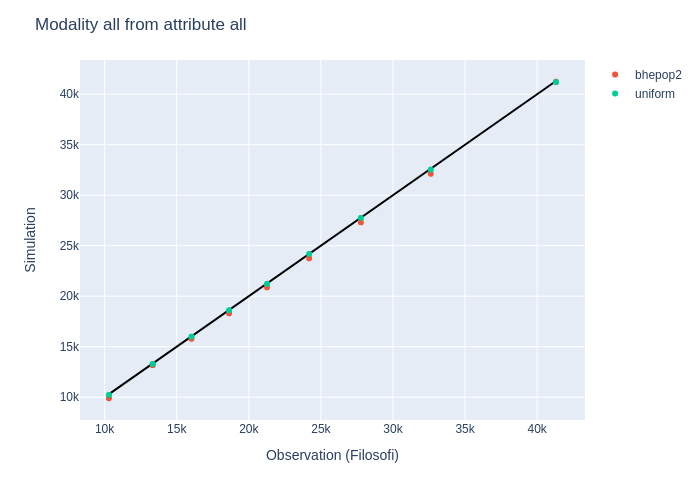

In [7]:
Image(analysis.plot_analysis_compare("all", "all").to_image())

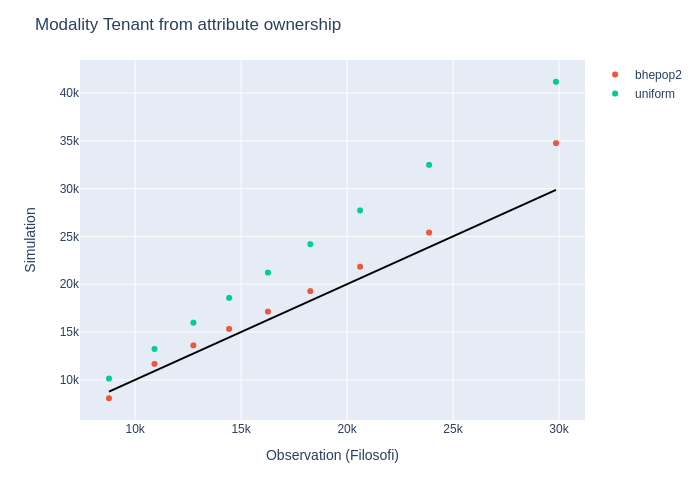

In [8]:
Image(analysis.plot_analysis_compare("ownership", "Tenant").to_image())


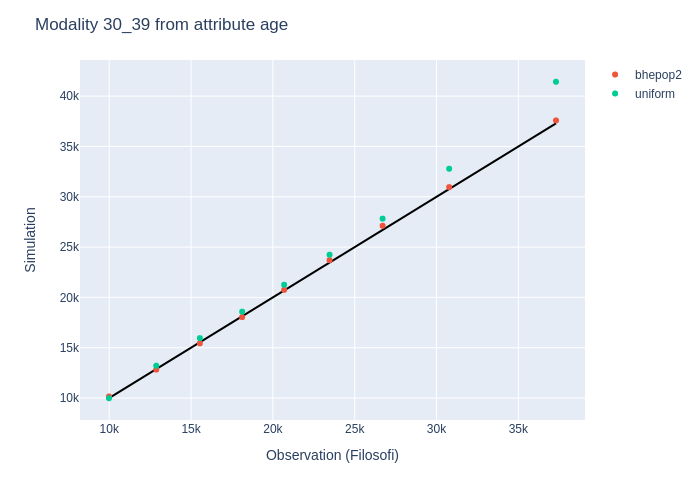

In [9]:
Image(analysis.plot_analysis_compare("age", "30_39").to_image())

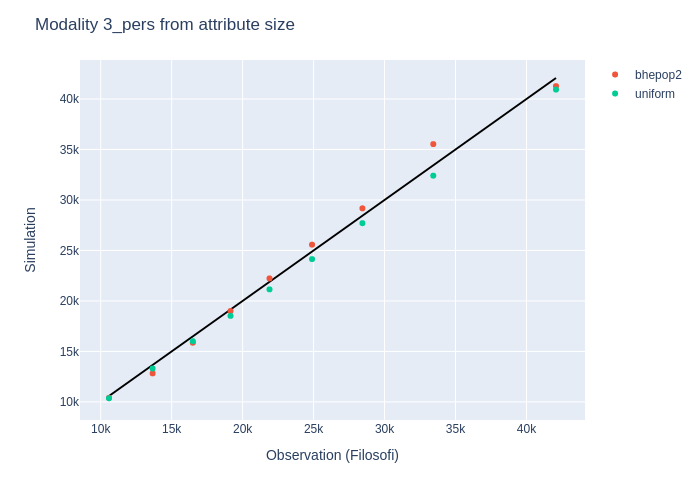

In [10]:
Image(analysis.plot_analysis_compare("size", "3_pers").to_image())

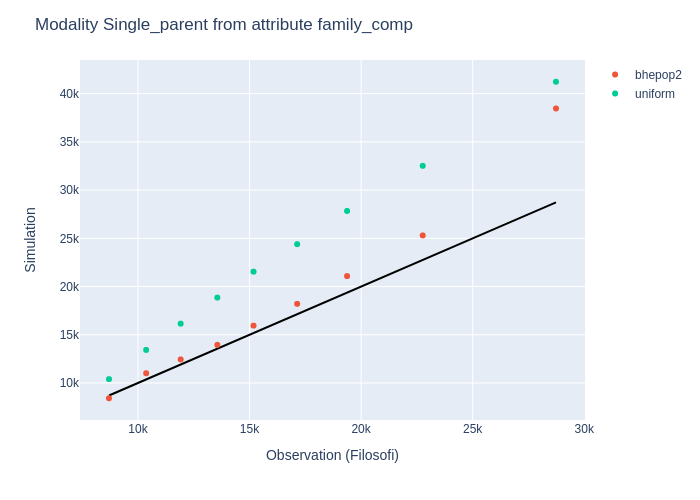

In [11]:
Image(analysis.plot_analysis_compare("family_comp", "Single_parent").to_image())